# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils import data

from typing import Any
from math import sqrt

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch

    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """

    for i, (inputs, targets) in enumerate(train_loader):
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
        model.zero_grad()

        out = model(inputs)
        loss = F.nll_loss(out, targets)

        loss.backward()
        optimizer.step()

        if i % log_interval == 0:
            print(loss)

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics

    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0

    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()

            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability

            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()

            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10

                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0

                # disable axis and show image
                axis[y][x].axis("off")
                axis[y][x].imshow(img)

                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())

                plotted += 1
                img_idx += 1

    test_loss /= len(test_loader.dataset)

    # show results
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNetGeneral(nn.Module):
    def __init__(self, activation: Any = nn.Sigmoid, batchnorm=False):
        super().__init__()

        layer_sizes = [784, 200, 100, 60, 30, 10]
        layers: list[Any] = [nn.Flatten()]
        gain = 1
        if activation != nn.Sigmoid:
            gain = sqrt(2)
        for i in range(len(layer_sizes) - 1):
            indim, outdim = layer_sizes[i], layer_sizes[i + 1]
            layer = nn.Linear(indim, outdim)
            nn.init.xavier_uniform_(layer.weight, gain=gain)
            layers.append(layer)
            if i != len(layer_sizes) - 2:
                layers.append(activation())
            if batchnorm and i in (0, 2):
                layers.append(nn.BatchNorm1d(outdim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x.reshape(x.shape[0], -1)
        output = F.log_softmax(self.model(x), dim=1)

        return output

In [5]:
class FCNet1(FCNetGeneral):
    """
    Fully Connected Neural Network

    Five fully connected layers with sigmoid non-linearity

    Dimensions
    784->200->100->60->30->10
    """

    def __init__(self):
        super().__init__(activation=nn.Sigmoid, batchnorm=False)

In [6]:
class FCNet2(FCNetGeneral):
    def __init__(self):
        super().__init__(activation=nn.ReLU, batchnorm=False)

In [7]:
class FCNet3(FCNetGeneral):
    def __init__(self):
        super().__init__(activation=nn.ReLU, batchnorm=True)

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [8]:
def initializer(gain):
    def init_weights(m):
        if type(m) in (nn.Linear, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=gain)

    return init_weights

In [9]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """

    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            #
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            #
            nn.Flatten(),
            #
            nn.Linear(12 * 12 * 64, 128),
            nn.ReLU(),
            #
            nn.Linear(128, 10),
        ]
        self.model = nn.Sequential(*layers)
        self.model.apply(initializer(sqrt(2)))

    def forward(self, x):
        x.reshape(x.shape[0], -1)
        output = F.log_softmax(self.model(x), dim=1)
        return output

In [10]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            #
            nn.Flatten(),
            #
            nn.Linear(12 * 12 * 64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            #
            nn.Linear(128, 10),
        ]
        self.model = nn.Sequential(*layers)
        self.model.apply(initializer(sqrt(2)))

    def forward(self, x):
        x.reshape(x.shape[0], -1)
        output = F.log_softmax(self.model(x), dim=1)
        return output

In [11]:
class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.Flatten(),
            #
            nn.Linear(12 * 12 * 64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            #
            nn.Linear(128, 10),
        ]
        self.model = nn.Sequential(*layers)
        self.model.apply(initializer(sqrt(2)))

    def forward(self, x):
        x.reshape(x.shape[0], -1)
        output = F.log_softmax(self.model(x), dim=1)
        return output

tensor(3.5630, grad_fn=<NllLossBackward0>)
tensor(0.1480, grad_fn=<NllLossBackward0>)
tensor(0.2357, grad_fn=<NllLossBackward0>)
tensor(0.0657, grad_fn=<NllLossBackward0>)
tensor(0.3559, grad_fn=<NllLossBackward0>)
tensor(0.1165, grad_fn=<NllLossBackward0>)
tensor(0.0656, grad_fn=<NllLossBackward0>)
tensor(0.0228, grad_fn=<NllLossBackward0>)
tensor(0.0567, grad_fn=<NllLossBackward0>)
tensor(0.0347, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0492, Accuracy: 9861/10000 (98.61%)



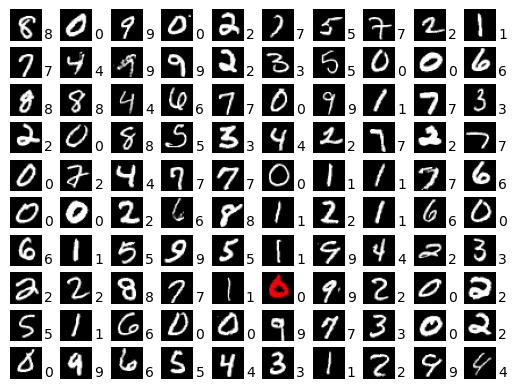

tensor(0.0817, grad_fn=<NllLossBackward0>)
tensor(0.0064, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0056, grad_fn=<NllLossBackward0>)
tensor(0.0670, grad_fn=<NllLossBackward0>)
tensor(0.0162, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)
tensor(0.0069, grad_fn=<NllLossBackward0>)
tensor(0.0791, grad_fn=<NllLossBackward0>)
tensor(0.0713, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.1305, Accuracy: 9815/10000 (98.15%)



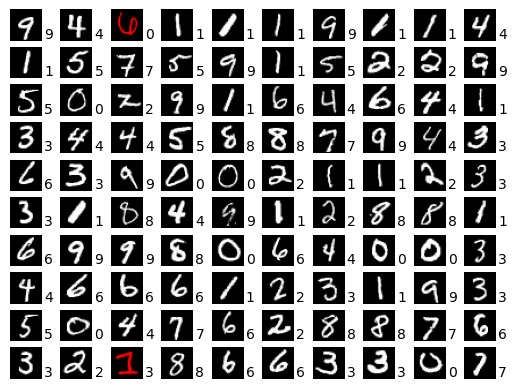

tensor(0.0276, grad_fn=<NllLossBackward0>)
tensor(0.0119, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0065, grad_fn=<NllLossBackward0>)
tensor(0.0059, grad_fn=<NllLossBackward0>)
tensor(0.0065, grad_fn=<NllLossBackward0>)
tensor(0.0335, grad_fn=<NllLossBackward0>)
tensor(0.1044, grad_fn=<NllLossBackward0>)
tensor(0.0113, grad_fn=<NllLossBackward0>)
tensor(0.0103, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0465, Accuracy: 9857/10000 (98.57%)



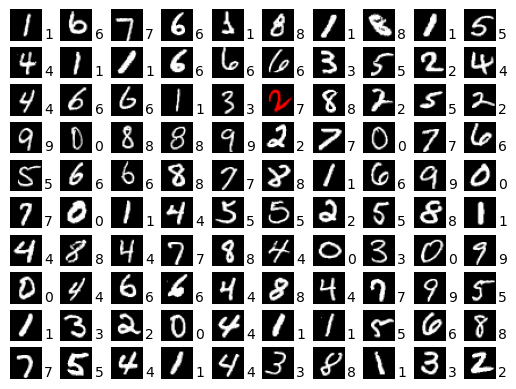

tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0157, grad_fn=<NllLossBackward0>)
tensor(0.0128, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.1056, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0331, Accuracy: 9888/10000 (98.88%)



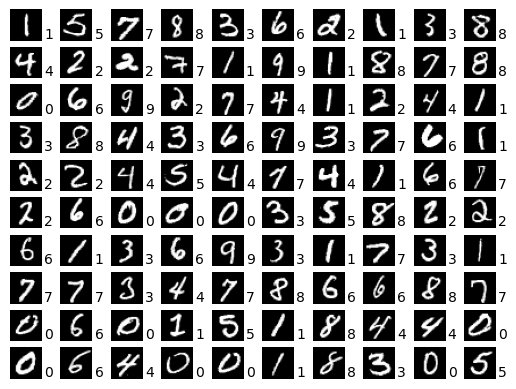

tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0335, Accuracy: 9907/10000 (99.07%)



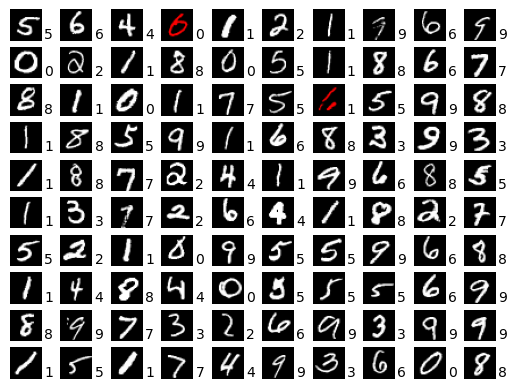

tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0122, grad_fn=<NllLossBackward0>)
tensor(0.0085, grad_fn=<NllLossBackward0>)
tensor(0.0044, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0329, Accuracy: 9904/10000 (99.04%)



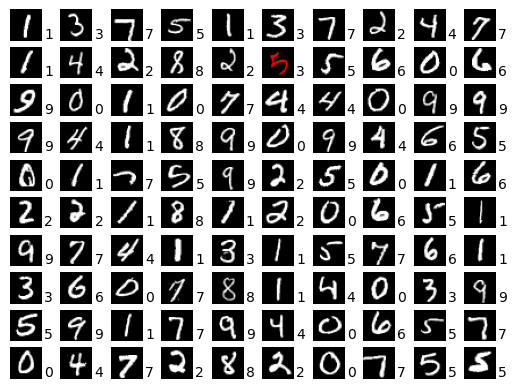

tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0100, grad_fn=<NllLossBackward0>)
tensor(0.0109, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0761, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0332, Accuracy: 9907/10000 (99.07%)



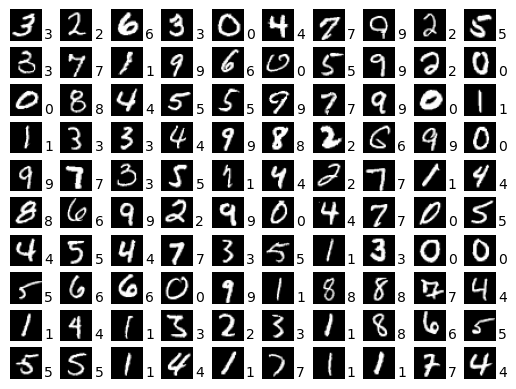

tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(4.4840e-05, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0335, Accuracy: 9909/10000 (99.09%)



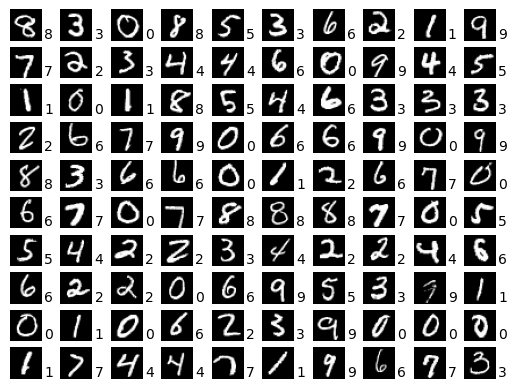

tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.1356, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(2.1536e-05, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0345, Accuracy: 9905/10000 (99.05%)



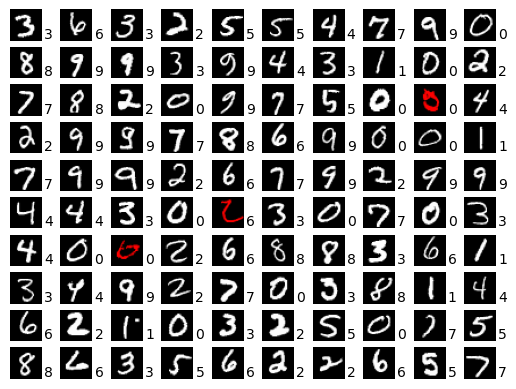

tensor(4.8425e-06, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0001, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)

Test set: Average loss: 0.0343, Accuracy: 9908/10000 (99.08%)



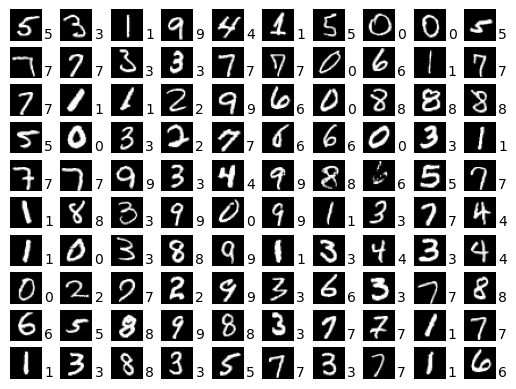

In [12]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# initialize data loaders
train_loader = data.DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

test_loader = data.DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=test_batch_size,
    shuffle=True,
    **kwargs
)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")